In [84]:
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree   
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [71]:
def title(str):
    ch = str.split(',')
    title = ch[1].split('.')
    return title[0]

# Import data

In [72]:
path="C:\\Users\\omarb\\Documents\\Introduction to AI\\Jupyter\\Datasets\\"
df = pd.read_csv(path+"titanic-passengers.csv",sep=';')
df.info()
df.isnull().sum() # Dataset seem already cleaned
df
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    object 
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Preprocess

In [73]:
data = df
## Cabin
A=data['Cabin'].mode()[0]
data['Cabin'].fillna(A,inplace=True)
## Embarked
Mostfreq=data.Embarked.value_counts().index[0]
data['Embarked'].fillna(Mostfreq,inplace=True)
one_hot = pd.get_dummies(data.Embarked)
#join one hot encoder
data = data.join(one_hot)
#drop column Embarked
data.drop('Embarked',axis=1, inplace=True)
## Age
data['Age'].fillna(data['Age'].mean(),inplace=True)
## Survived
SurvivedDict = {
    "Survived":{"No":0,"Yes":1}
}
data.replace(SurvivedDict,inplace=True)
## Sex
SexDict = {
    "Sex":{"male":0,"female":1}
}
data.replace(SexDict,inplace=True)
## Add FamSize
data['FamSize'] = data['Parch'] + data['SibSp']

## Add Title
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                     "Dr":         "Officer",
                    "Rev":        "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                   "Lady" :      "Royalty",
                  "the Countess": "Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Miss",
                    "Mlle":       "Miss",
                    "Miss" :      "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mrs",
                    "Mrs" :       "Mrs",
                    "Master" :    "Master"
                    }

data['Title'] = pd.Series(list(map(title,data.Name)))
data['Title'].update(pd.Series(Title_Dictionary))
data.drop('Name',axis=1,inplace=True)
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    object 
 10  C            891 non-null    uint8  
 11  Q            891 non-null    uint8  
 12  S            891 non-null    uint8  
 13  FamSize      891 non-null    int64  
 14  Title        891 non-null    object 
dtypes: float64(2), int64(7), object(3), uint8(3)
memory usage: 86.3+ KB


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S,FamSize,Title
0,343,0,2,0,28.0,0,0,248740,13.0000,B96 B98,0,0,1,0,Mr
1,76,0,3,0,25.0,0,0,348123,7.6500,F G73,0,0,1,0,Mr
2,641,0,3,0,20.0,0,0,350050,7.8542,B96 B98,0,0,1,0,Mr
3,568,0,3,1,29.0,0,4,349909,21.0750,B96 B98,0,0,1,4,Mrs
4,672,0,1,0,31.0,1,0,F.C. 12750,52.0000,B71,0,0,1,1,Mr
5,105,0,3,0,37.0,2,0,3101276,7.9250,B96 B98,0,0,1,2,Mr
6,576,0,3,0,19.0,0,0,358585,14.5000,B96 B98,0,0,1,0,Mr
7,382,1,3,1,1.0,0,2,2653,15.7417,B96 B98,1,0,0,2,Miss
8,228,0,3,0,20.5,0,0,A/5 21173,7.2500,B96 B98,0,0,1,0,Mr
9,433,1,2,1,42.0,1,0,SC/AH 3085,26.0000,B96 B98,0,0,1,1,Mrs


In [74]:
data = data[['PassengerId','Survived','Title','Pclass','Sex','Age',
             'Ticket','Fare','Cabin','C','Q','S','FamSize']]
data

,PassengerId,Survived,Title,Pclass,Sex,Age,Ticket,Fare,Cabin,C,Q,S,FamSize
0,343,0,Mr,2,0,28.000000,248740,13.0000,B96 B98,0,0,1,0
1,76,0,Mr,3,0,25.000000,348123,7.6500,F G73,0,0,1,0
2,641,0,Mr,3,0,20.000000,350050,7.8542,B96 B98,0,0,1,0
3,568,0,Mrs,3,1,29.000000,349909,21.0750,B96 B98,0,0,1,4
4,672,0,Mr,1,0,31.000000,F.C. 12750,52.0000,B71,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,10,1,Mrs,2,1,14.000000,237736,30.0708,B96 B98,1,0,0,1
887,61,0,Mr,3,0,22.000000,2669,7.2292,B96 B98,1,0,0,0
888,535,0,Miss,3,1,30.000000,315084,8.6625,B96 B98,0,0,1,0
889,102,0,Mr,3,0,29.699118,349215,7.8958,B96 B98,0,0,1,0


In [146]:
# Input/Output
#x = data.drop(['PassengerId','Survived','Cabin','Title','Ticket'],axis=1).values
x = data[['Age','Sex','Pclass']].values
y = data.Survived.values
# Split Data
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=0.15,random_state=1)

In [147]:
# Decision Tree Model
depth = 2
DecTree = tree.DecisionTreeClassifier(max_depth=depth,criterion='gini')
DecTree.fit(x_train,y_train)


DecisionTreeClassifier(max_depth=2)

In [150]:
y_pred = DecTree.predict(x_test)
print("score:{}".format(accuracy_score(y_test, y_pred)))

score:0.8059701492537313


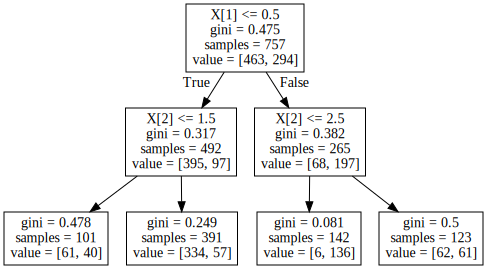

In [151]:
dot_data = tree.export_graphviz(DecTree,out_file=None)
graph = graphviz.Source(dot_data)
graph.render()
graph

In [152]:
# choose one test example
x_test_ex= x_test[10]

Using the graph above
Features:
- Sex > 0.5
- Pclass <= 1.5 

Output :  True


In [153]:
y_pred_ex = DecTree.predict(x_test_ex.reshape(1, -1))
y_pred

array([1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0], dtype=int64)

In [205]:
# loop over max_depth to calculate best one
score = 0
best_depth = 0
for i in range(1,20):
    DecTree = tree.DecisionTreeClassifier(max_depth=i,criterion='gini')
    DecTree.fit(x_train,y_train)
    y_pred =  DecTree.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print('tree depth:{} '.format(i)+"score:{}".format(accuracy_score(y_test, y_pred)))
    if acc>score:
        score = acc
        best_depth = i
print(best_depth,score)

tree depth:1 score:0.8134328358208955
tree depth:2 score:0.8059701492537313
tree depth:3 score:0.8208955223880597
tree depth:4 score:0.8432835820895522
tree depth:5 score:0.835820895522388
tree depth:6 score:0.8283582089552238
tree depth:7 score:0.8208955223880597
tree depth:8 score:0.8134328358208955
tree depth:9 score:0.8283582089552238
tree depth:10 score:0.8283582089552238
tree depth:11 score:0.8507462686567164
tree depth:12 score:0.8507462686567164
tree depth:13 score:0.8582089552238806
tree depth:14 score:0.8582089552238806
tree depth:15 score:0.8582089552238806
tree depth:16 score:0.8582089552238806
tree depth:17 score:0.8656716417910447
tree depth:18 score:0.8582089552238806
tree depth:19 score:0.8656716417910447
0.8656716417910447 17


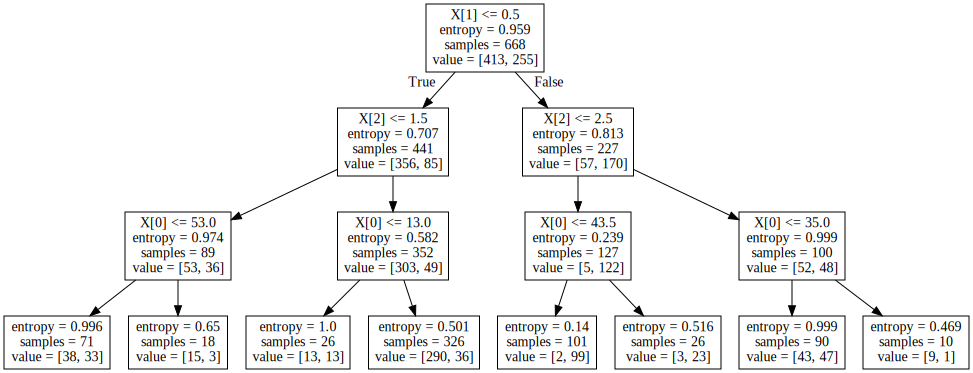

In [83]:
dot_data = tree.export_graphviz(DecTree,out_file=None)
graph = graphviz.Source(dot_data)
graph.render()
graph

# Radom Forest

In [157]:
# Split Data
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=0.15,random_state=1)

In [158]:
RanFo = RandomForestClassifier(n_estimators=5)
RanFo.fit(x_train,y_train)
y_pred = RanFo.predict(x_test)
print("score:{}".format(accuracy_score(y_test, y_pred)))

score:0.8507462686567164


In [206]:
# loop over n_estimators to calculate best one
score = 0
best_n = 1
for i in range(1,100):
    RanFo = RandomForestClassifier(n_estimators=50,max_depth=best_depth)
    RanFo.fit(x_train,y_train)
    y_pred = RanFo.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print('n:{} '.format(i)+"score:{}".format(accuracy_score(y_test, y_pred)))
    if acc>score:
        score = acc
        best_n = i
print(score,best_n)

n:1 score:0.8432835820895522
n:2 score:0.8507462686567164
n:3 score:0.8432835820895522
n:4 score:0.8582089552238806
n:5 score:0.8582089552238806
n:6 score:0.8582089552238806
n:7 score:0.8582089552238806
n:8 score:0.8507462686567164
n:9 score:0.8582089552238806
n:10 score:0.8432835820895522
n:11 score:0.8432835820895522
n:12 score:0.8507462686567164
n:13 score:0.8507462686567164
n:14 score:0.8582089552238806
n:15 score:0.8582089552238806
n:16 score:0.8432835820895522
n:17 score:0.8582089552238806
n:18 score:0.8656716417910447
n:19 score:0.8507462686567164
n:20 score:0.8507462686567164
n:21 score:0.8656716417910447
n:22 score:0.8507462686567164
n:23 score:0.8582089552238806
n:24 score:0.8656716417910447
n:25 score:0.8656716417910447
n:26 score:0.8582089552238806
n:27 score:0.8507462686567164
n:28 score:0.8507462686567164
n:29 score:0.8656716417910447
n:30 score:0.8582089552238806
n:31 score:0.8507462686567164
n:32 score:0.8582089552238806
n:33 score:0.8582089552238806
n:34 score:0.850746

In [207]:
RanFo = RandomForestClassifier(n_estimators=best_n,max_depth=best_depth)
RanFo.fit(x_train,y_train)
y_pred = RanFo.predict(x_test)
print("score:{}".format(accuracy_score(y_test, y_pred)))

score:0.8507462686567164
